# YOLO object detection with OpenCV

### Import Packages

In [2]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import time
import cv2
import os

Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### YOLO object detection in images

In [4]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "image": "images/baggage_claim.jpg",
    "yolo": "yolo-coco",
    "confidence": 0.5,
    "threshold": 0.3
}

In [5]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [6]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])

# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [7]:
# load our input image and grab its spatial dimensions
image = cv2.imread(args["image"])
(H, W) = image.shape[:2]

# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 2.430473 seconds


In [8]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

In [9]:
# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
		
        # filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > args["confidence"]:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			
            # use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
			
            # update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [10]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"],
	args["threshold"])

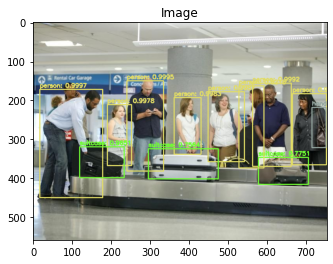

In [11]:
# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, color, 2)

# show the output image
plt_imshow("Image", image)

### YOLO object detection in video streams

In [12]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "input": "videos/airport.mp4",
    "output": "output/airport.avi",
    "yolo": "yolo-coco",
    "confidence": 0.5,
    "threshold": 0.3
}

In [13]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])

# load our YOLO object detector trained on COCO dataset (80 classes)
# and determine only the *output* layer names that we need from YOLO
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

[INFO] loading YOLO from disk...


In [14]:
# initialize the video stream, pointer to output video file, and
# frame dimensions
vs = cv2.VideoCapture(args["input"])
writer = None
(W, H) = (None, None)

# try to determine the total number of frames in the video file
try:
	prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
		else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	print("[INFO] {} total frames in video".format(total))

# an error occurred while trying to determine the total
# number of frames in the video file
except:
	print("[INFO] could not determine # of frames in video")
	print("[INFO] no approx. completion time can be provided")
	total = -1

[INFO] 749 total frames in video


In [15]:
# loop over frames from the video file stream
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()

	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break

	# if the frame dimensions are empty, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]

	# construct a blob from the input frame and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes
	# and associated probabilities
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)
	net.setInput(blob)
	start = time.time()
	layerOutputs = net.forward(ln)
	end = time.time()

	# initialize our lists of detected bounding boxes, confidences,
	# and class IDs, respectively
	boxes = []
	confidences = []
	classIDs = []

	# loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability)
			# of the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# filter out weak predictions by ensuring the detected
			# probability is greater than the minimum probability
			if confidence > args["confidence"]:
				# scale the bounding box coordinates back relative to
				# the size of the image, keeping in mind that YOLO
				# actually returns the center (x, y)-coordinates of
				# the bounding box followed by the boxes' width and
				# height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")

				# use the center (x, y)-coordinates to derive the top
				# and and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))

				# update our list of bounding box coordinates,
				# confidences, and class IDs
				boxes.append([x, y, int(width), int(height)])
				confidences.append(float(confidence))
				classIDs.append(classID)

	# apply non-maxima suppression to suppress weak, overlapping
	# bounding boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"],
		args["threshold"])

	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])

			# draw a bounding box rectangle and label on the frame
			color = [int(c) for c in COLORS[classIDs[i]]]
			cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
			text = "{}: {:.4f}".format(LABELS[classIDs[i]],
				confidences[i])
			cv2.putText(frame, text, (x, y - 5),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

	# check if the video writer is None
	if writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 30,
			(frame.shape[1], frame.shape[0]), True)

		# some information on processing single frame
		if total > 0:
			elap = (end - start)
			print("[INFO] single frame took {:.4f} seconds".format(elap))
			print("[INFO] estimated total time to finish: {:.4f}".format(
				elap * total))

	# write the output frame to disk
	writer.write(frame)

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

[INFO] single frame took 2.2090 seconds
[INFO] estimated total time to finish: 1654.5773
[INFO] cleaning up...


The above code block takes a while to complete its execution.

Our output video is produced in `.avi` format. First, we need to convert it to `.mp4` format. 

In [18]:
!ffmpeg -i "output/airport.avi" output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [19]:
#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)